# Import Libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tracemalloc
import random

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors


# Optional: Set style for plots
sns.set(style="whitegrid")

# %matplotlib inline (for notebook environments only)

# Load embeddings and game dataframe

We load the final embedding matrix and the corresponding game dataframe.  
The embeddings are normalized and will be used directly for clustering.  
We also check the dimensions to make sure the rows align.

In [74]:
# Load embeddings and game metadata
emb_norm = np.load("../data/embeddings_FINAL.npy") 
df = pd.read_pickle("../data/games_df_FINAL.pkl")

# Check shapes
print("Embeddings shape:", emb_norm.shape)
print("Games dataframe shape:", df.shape)

Embeddings shape: (10476, 384)
Games dataframe shape: (10476, 11)


# Helper Functions

In [75]:
def track_memory_and_time(func):
    """
    Decorator to track memory usage and execution time of a function
    """
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        start_time = time.time()
        result = func(*args, **kwargs)
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        elapsed = time.time() - start_time
        print(f"Time: {elapsed:.2f} seconds | Peak memory: {peak / 1024**2:.2f} MB")
        return result
    return wrapper

In [76]:
def inspect_clusters(df, cluster_col="cluster_kmeans", n_clusters=4, n_samples=5, display_cols=None):
    """
    Print sample games from selected clusters.
    
    Always includes cluster 0 (if it exists), and randomly selects the remaining.
    """
    if display_cols is None:
        display_cols = ["name", "summary", "genres", "platforms"]
    
    unique_clusters = sorted(df[cluster_col].dropna().unique())
    
    if len(unique_clusters) == 0:
        print("No clusters found.")
        return
    
    clusters_to_show = []
    if 0 in unique_clusters:
        clusters_to_show.append(0)
        remaining_clusters = [c for c in unique_clusters if c != 0]
    else:
        remaining_clusters = unique_clusters
    
    random.seed(42)
    clusters_to_show += random.sample(remaining_clusters, min(n_clusters - len(clusters_to_show), len(remaining_clusters)))

    for cluster_id in clusters_to_show:
        print("=" * 80)
        count = df[df[cluster_col] == cluster_id].shape[0]
        print(f"Cluster {cluster_id} — {count} games")
        print("=" * 80)
        
        sample = df[df[cluster_col] == cluster_id][display_cols].sample(n=min(n_samples, count), random_state=42)
        display(sample)

In [77]:
def evaluate_clustering(X, labels):
    """
    Compute Silhouette and Davies-Bouldin scores
    """
    if len(set(labels)) <= 1 or (len(set(labels)) == 2 and -1 in labels):
        print("Not enough clusters for evaluation")
        return None, None

    silhouette = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies–Bouldin Index: {db_index:.4f}")

In [78]:
def plot_clusters(X, labels, title="Cluster Plot", figsize=(8,6)):
    """
    Plot clustering results using both PCA and t-SNE for visualization
    """
    fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*2, figsize[1]))

    # PCA projection
    pca = PCA(n_components=2)
    reduced_pca = pca.fit_transform(X)
    scatter_pca = axs[0].scatter(reduced_pca[:, 0], reduced_pca[:, 1], c=labels, cmap="Set1", alpha=0.7)
    axs[0].set_title("PCA Projection")
    axs[0].set_xlabel("PCA 1")
    axs[0].set_ylabel("PCA 2")
    fig.colorbar(scatter_pca, ax=axs[0])

    # t-SNE projection
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    reduced_tsne = tsne.fit_transform(X)
    scatter_tsne = axs[1].scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], c=labels, cmap="Set1", alpha=0.7)
    axs[1].set_title("t-SNE Projection")
    axs[1].set_xlabel("t-SNE 1")
    axs[1].set_ylabel("t-SNE 2")
    fig.colorbar(scatter_tsne, ax=axs[1])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Apply KMeans Clustering

We apply the KMeans clustering algorithm on the normalized embeddings.  
We choose a number of clusters `k = 20` based on the approximate size and diversity of the dataset.  
After fitting the model, we assign each game to a cluster.

##### Determine Optimal Number of Clusters with Elbow Method

To identify the most suitable number of clusters for KMeans, we use the **Elbow Method**.

This method involves the following steps:

1. We run **KMeans** for different values of k (number of clusters).
2. For each k, we compute the **inertia**, which is the within-cluster sum of squared distances (SSE).
3. We plot k versus inertia. The optimal k is typically at the "elbow" point — where the inertia starts decreasing more slowly.

This helps us balance between underfitting (too few clusters) and overfitting (too many clusters), and choose a value of k that offers a good trade-off between compactness and efficiency.

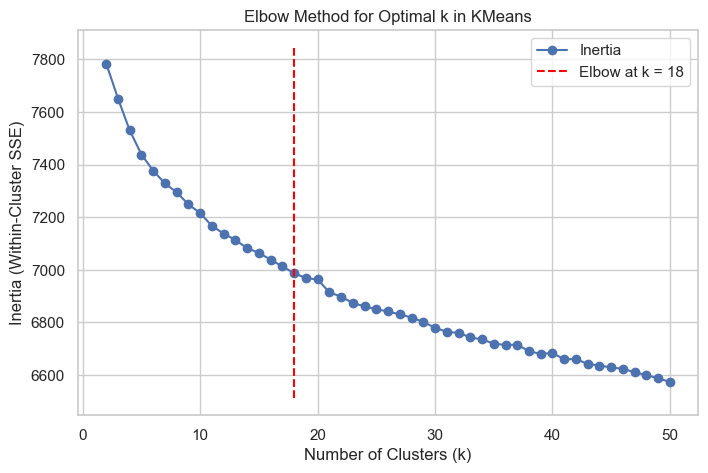

Optimal number of clusters (k) found by Elbow Method: 18


In [79]:
# Compute inertias for different k
inertias = []
k_values = list(range(2, 51))  # k from 2 to 50

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(emb_norm)
    inertias.append(kmeans.inertia_)

# Detect elbow point automatically
knee = KneeLocator(k_values, inertias, curve="convex", direction="decreasing")
k_optimal = knee.elbow

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o', label="Inertia")
plt.vlines(k_optimal, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label=f"Elbow at k = {k_optimal}")
plt.title("Elbow Method for Optimal k in KMeans")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.grid(True)
plt.legend()
plt.show()

# Report optimal k
print(f"Optimal number of clusters (k) found by Elbow Method: {k_optimal}")

In [80]:
@track_memory_and_time
def run_kmeans_clustering(X, n_clusters=20, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init="auto")
    labels = kmeans.fit_predict(X)
    return labels

# Run KMeans
kmeans_labels = run_kmeans_clustering(emb_norm, n_clusters=k_optimal)

# Assign to dataframe
df["cluster_kmeans"] = kmeans_labels

# Check basic cluster stats
print("Number of clusters found:", df["cluster_kmeans"].nunique())
print(df["cluster_kmeans"].value_counts().sort_index())

Time: 0.23 seconds | Peak memory: 30.73 MB
Number of clusters found: 18
cluster_kmeans
0     810
1     666
2     785
3     341
4     993
5     428
6     554
7     416
8     602
9     443
10    651
11    643
12    798
13    306
14    500
15    394
16    524
17    622
Name: count, dtype: int64


### Inspect KMeans Clusters

Let's look at a few clusters found by KMeans and inspect some sample games from each cluster.  
We display the name, summary, genres, and platforms to evaluate the internal coherence of the clusters.

In [81]:
inspect_clusters(df, cluster_col="cluster_kmeans")

Cluster 0 — 810 games


,name,summary,genres,platforms
2954,Hitman 3: Chongqing,Under the flickering neon lights of busy cafes...,Adventure,PC (Microsoft Windows)
8387,Golden Rails: World's Fair,The mayor of your hometown needs your help con...,"Adventure, Indie, Strategy",PC (Microsoft Windows)
2650,Archaeology: Frozen Village,A game of the genre find the hidden object.,"Adventure, Indie, Racing, Role-playing (RPG), ...","Linux, Mac, PC (Microsoft Windows)"
3312,Ark: The Center Ascended,The Center is a free add-on for ARK: Survival ...,"Adventure, Indie, Role-playing (RPG)",PC (Microsoft Windows)
6590,Monster Adventure,In this game for kids full of weird characters...,"Adventure, Indie",PC (Microsoft Windows)


Cluster 4 — 993 games


,name,summary,genres,platforms
9643,Snapback,Snapback is a Speed-Runner Puzzle Platformer s...,Indie,PC (Microsoft Windows)
5663,Gaserb,Gaserb contains difficult puzzles that can be ...,"Indie, Platform, Puzzle",PC (Microsoft Windows)
6053,Aggressive Robot Vacuum,Aggressive Robot Vacuum-a robot vacuum cleaner...,"Indie, Simulator",PC (Microsoft Windows)
7059,Achievement Creator,"Create and send us your own art, meme or fun i...","Indie, Simulator",PC (Microsoft Windows)
9620,Gold Wiper,Gold Wiper is an arcade game like Qix and Gals...,Indie,PC (Microsoft Windows)


Cluster 1 — 666 games


,name,summary,genres,platforms
9845,DROD: King Dugan's Dungeon,What happened to Beethro on his first excursio...,"Adventure, Indie, Puzzle, Strategy",PC (Microsoft Windows)
2598,Square Enix AI Tech Preview: The Portopia Seri...,This software is an educational demonstration ...,"Adventure, Point-and-click",PC (Microsoft Windows)
10095,SCP: Nine-Tailed Fox,Experience the horrors of being the one suppos...,"Adventure, Indie, Shooter",PC (Microsoft Windows)
3843,Sophie's Safecracking Simulator,Crack simulated safe locks using real techniques!,"Puzzle, Simulator","Linux, Mac, PC (Microsoft Windows)"
7977,Blood Knuckle: Rooftop of The Impossible Skysc...,"Use your giant fist to punch, puzzle and scale...","Adventure, Indie",PC (Microsoft Windows)


Cluster 12 — 798 games


,name,summary,genres,platforms
9173,Shadow of the Tomb Raider: The Serpent's Heart,Experience “The Serpent’s Heart” DLC and endur...,"Adventure, Shooter","Google Stadia, Linux, Mac, PC (Microsoft Windo..."
8807,Summoned By Accident,Summoned by Accident is a text based rpg focus...,"Adventure, Role-playing (RPG)","Linux, Mac, PC (Microsoft Windows)"
638,Wartile: Hel's Nightmare,Enjoy five brand new handcrafted battle boards...,"Indie, Role-playing (RPG), Strategy",PC (Microsoft Windows)
6766,Conquer and Breed the Demon Queen,After getting kicked out of the Hero's party f...,Visual Novel,"Android, Linux, Mac, PC (Microsoft Windows)"
670,Conqueror's Blade: Season II - Wrath of the No...,A realm of infinite opportunity draws aspiring...,"Role-playing (RPG), Strategy",PC (Microsoft Windows)


### Evaluate KMeans Clustering

We evaluate the KMeans clusters using two common metrics:

- **Silhouette Score**: Measures how similar each point is to its own cluster vs. other clusters. Higher is better. Range: [-1, 1]
- **Davies–Bouldin Index**: Measures the average similarity between each cluster and its most similar one. Lower is better.

These metrics help assess whether the clusters are compact and well-separated.

In [82]:
evaluate_clustering(emb_norm, df["cluster_kmeans"])

Silhouette Score: 0.0138
Davies–Bouldin Index: 4.8103


### Visualize KMeans Clustering

To better understand the clustering, we project the high-dimensional embeddings into 2D using **PCA** and **t-SNE**. Each point is colored based on its assigned KMeans cluster.

/Users/ignacioripollgonzalez/Library/Mobile Documents/com~apple~CloudDocs/NACHO/DTU/2. MSc BUSINESS ANALYTICS/MScBA/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


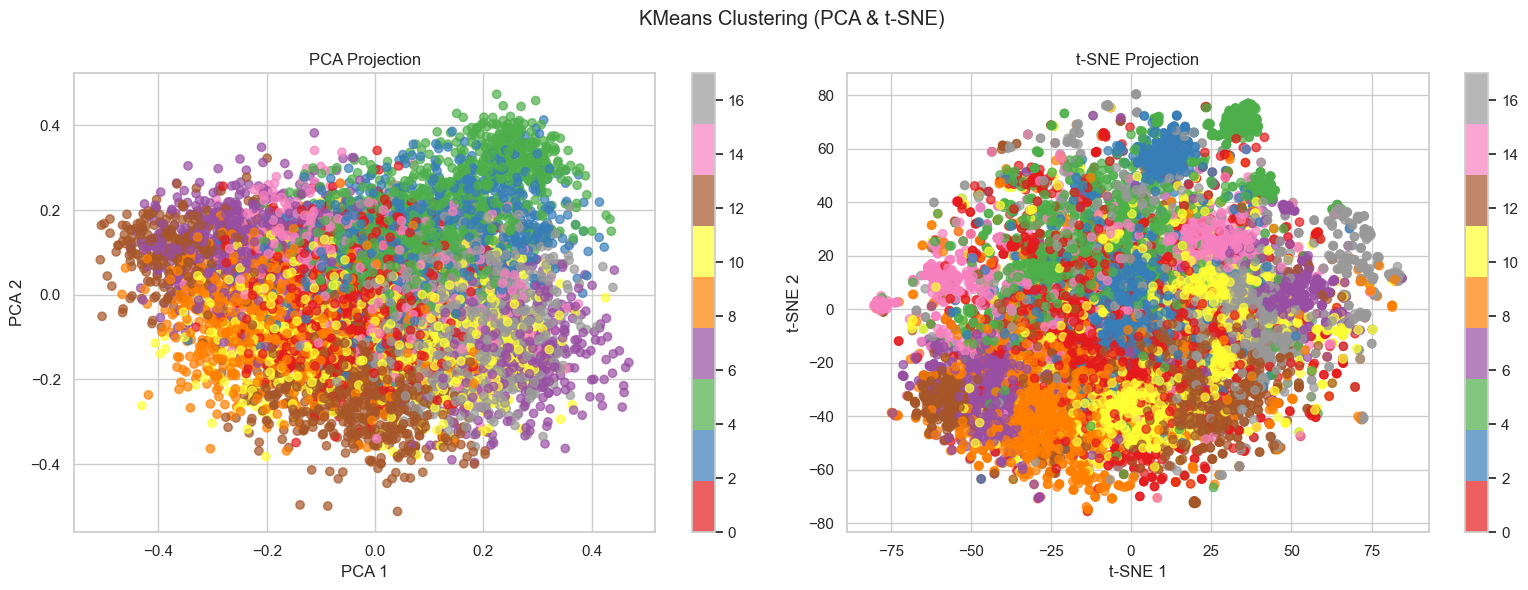

In [83]:
# Visualize the KMeans clustering results with PCA and t-SNE
plot_clusters(emb_norm, df["cluster_kmeans"], title="KMeans Clustering (PCA & t-SNE)")

### Save DataFrame with KMeans Clusters

We now save the DataFrame that includes the original metadata and the KMeans cluster assignments.

In [84]:
output_path = "../data/kmeans_results.pkl"
df.to_pickle(output_path)
print(f"DataFrame saved to: {output_path}")

DataFrame saved to: ../data/kmeans_results.pkl


# Apply DBSCAN Clustering

We apply the DBSCAN clustering algorithm on the normalized embeddings.  
DBSCAN is a density-based clustering method that can automatically detect outliers (labelled as -1) and doesn’t require predefining the number of clusters.  
We set the parameters eps and min_samples based on empirical testing.

In [85]:
@track_memory_and_time
def search_best_dbscan_params(X, min_samples_list, metric="silhouette"):
    """
    Try different min_samples values, estimate optimal eps using KneeLocator,
    evaluate DBSCAN, and return best parameters and summary dataframe.

    metric: 'silhouette' or 'db_index'
    """
    results = []

    for min_samples in min_samples_list:
        # Step 1: Compute k-distance plot
        neighbors = NearestNeighbors(n_neighbors=min_samples)
        neighbors_fit = neighbors.fit(X)
        distances, indices = neighbors_fit.kneighbors(X)
        k_distances = np.sort(distances[:, -1])  # distance to k-th neighbor

        # Step 2: KneeLocator to find eps
        kneedle = KneeLocator(range(1, len(k_distances) + 1), k_distances, S=1.0, curve="convex", direction="increasing")
        eps = kneedle.knee_y

        if eps is None:
            print(f"No clear knee found for min_samples={min_samples}. Skipping...")
            continue

        # Step 3: Run DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(X)

        # Step 4: Evaluate only if enough clusters
        if len(set(labels)) > 1 and not (len(set(labels)) == 2 and -1 in labels):
            silhouette = silhouette_score(X, labels)
            db_index = davies_bouldin_score(X, labels)
        else:
            silhouette = None
            db_index = None

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)

        results.append({
            "min_samples": min_samples,
            "eps": round(eps, 4),
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette": silhouette,
            "db_index": db_index
        })

    # Convert to DataFrame
    df_results = pd.DataFrame(results)

    # Find best row
    if not df_results.empty and metric in ["silhouette", "db_index"]:
        valid = df_results[df_results[metric].notna()]
        if not valid.empty:
            if metric == "silhouette":
                best_row = valid.loc[valid[metric].idxmax()]
            else:  # db_index
                best_row = valid.loc[valid[metric].idxmin()]

            eps_optimal = best_row["eps"]
            min_samples_optimal = best_row["min_samples"]
            print(f"\nBest DBSCAN parameters based on {metric}:")
            print(f"   ➤ eps = {eps_optimal}")
            print(f"   ➤ min_samples = {min_samples_optimal}")
        else:
            eps_optimal = None
            min_samples_optimal = None
            print("No valid clustering configurations for evaluation.")
    else:
        eps_optimal = None
        min_samples_optimal = None
        print("No results or invalid metric provided.")

    return df_results, eps_optimal, min_samples_optimal

In [86]:
min_samples_list = range(1,101)

In [87]:
df_dbscan_results, eps_optimal, min_samples_optimal = search_best_dbscan_params(emb_norm, min_samples_list=min_samples_list, metric="silhouette")
display(df_dbscan_results)


Best DBSCAN parameters based on silhouette:
   ➤ eps = 1.0618
   ➤ min_samples = 2.0
Time: 135.02 seconds | Peak memory: 2558.81 MB


,min_samples,eps,n_clusters,n_noise,silhouette,db_index
0,1,0.0000,10474,1,0.000191,2.780001e-08
1,2,1.0618,2,61,0.047416,4.628891e+00
2,3,1.0789,1,32,NaN,NaN
3,4,1.0874,1,24,NaN,NaN
4,5,1.0828,1,30,NaN,NaN
...,...,...,...,...,...,...
95,96,1.1730,1,0,NaN,NaN
96,97,1.1755,1,0,NaN,NaN
97,98,1.1679,1,0,NaN,NaN
98,99,1.1815,1,0,NaN,NaN


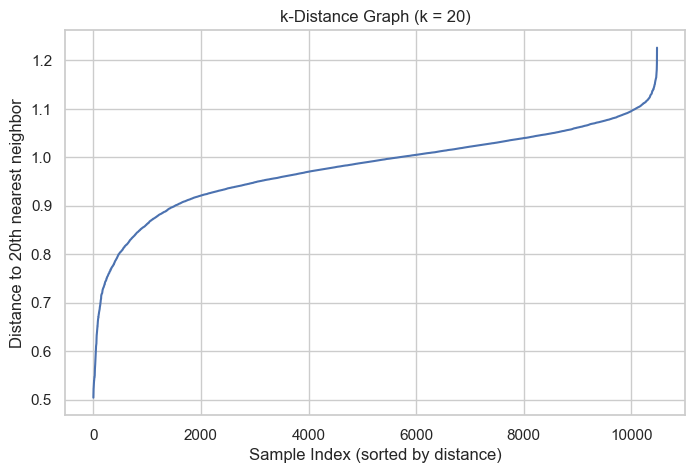

Suggested eps from k-distance elbow: 1.1407


In [57]:
# Set candidate min_samples value
min_samples_candidate = 20

# Fit Nearest Neighbors model
neighbors = NearestNeighbors(n_neighbors=min_samples_candidate)
neighbors_fit = neighbors.fit(emb_norm)
distances, indices = neighbors_fit.kneighbors(emb_norm)

# Use the k-th nearest neighbor distance (i.e., last column)
k_distances = np.sort(distances[:, -1])  # shape (n_samples,)

# Plot the sorted distances
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.title(f"k-Distance Graph (k = {min_samples_candidate})")
plt.xlabel("Sample Index (sorted by distance)")
plt.ylabel(f"Distance to {min_samples_candidate}th nearest neighbor")
plt.grid(True)
plt.show()

# Find the elbow using KneeLocator
kneedle = KneeLocator(range(len(k_distances)), k_distances, curve="convex", direction="increasing")
eps_optimal = k_distances[kneedle.knee] if kneedle.knee else None

print(f"Suggested eps from k-distance elbow: {eps_optimal:.4f}" if eps_optimal else "Elbow not detected. Try adjusting min_samples.")

In [90]:
@track_memory_and_time
def run_dbscan_clustering(X, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = dbscan.fit_predict(X)
    return labels

# Run DBSCAN
dbscan_labels = run_dbscan_clustering(emb_norm, eps=eps_optimal, min_samples=int(min_samples_optimal))

# Assign to dataframe
df["cluster_dbscan"] = dbscan_labels

# Check basic cluster stats
print("Number of clusters found (excluding noise):", len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0))
print("Number of noise points (label -1):", (dbscan_labels == -1).sum())
print(df["cluster_dbscan"].value_counts().sort_index())

Time: 0.50 seconds | Peak memory: 33.16 MB
Number of clusters found (excluding noise): 2
Number of noise points (label -1): 61
cluster_dbscan
-1       61
 0    10413
 1        2
Name: count, dtype: int64


### Inspect DBSCAN Clusters

Let’s look at a few clusters found by **DBSCAN** and inspect some sample games from each cluster.  
We display the name, summary, genres, and platforms to evaluate the internal coherence of the clusters.  
Note that cluster -1 corresponds to **noise points**, i.e., games that were not assigned to any cluster.

In [91]:
inspect_clusters(df, cluster_col="cluster_dbscan")

Cluster 0 — 10413 games


,name,summary,genres,platforms
958,Wave Break,Grab and grind to your heart's content in Wave...,"Arcade, Indie, Shooter, Simulator, Sport","Google Stadia, Linux, Nintendo Switch, PC (Mic..."
4748,Yello Bandana,"Well, there is only one character in this game...",Indie,PC (Microsoft Windows)
8391,Pixel Traffic: Risky Bridge,Drive your car and get to the end of the bridg...,"Indie, Racing","Linux, Mac, PC (Microsoft Windows)"
10394,Cyrah's Ascent,Cyrah's Ascent is a third-person combat game w...,"Adventure, Indie",PC (Microsoft Windows)
4827,My boss is weird,"""My boss is weird"" is a career AVG choice play...",Indie,PC (Microsoft Windows)


Cluster -1 — 61 games


,name,summary,genres,platforms
498,Ignis Dei,"Heralded by a comet, seen as a harbinger of do...","Adventure, Indie",PC (Microsoft Windows)
1271,Geezer Gus: The Meteorite Motel,The Meteorite Motel is a surreal JRPG based up...,Role-playing (RPG),PC (Microsoft Windows)
8896,Napoleon: Total War - The Peninsular Campaign,The Peninsular Campaign Downloadable Content i...,Strategy,"Mac, PC (Microsoft Windows)"
5779,Invasion: Family Ties,"Rick travels to Indiana to visit his mother, b...",Adventure,PC (Microsoft Windows)
3374,Millivolt,You play as an electrical appliance repair rob...,"Adventure, Indie, Platform, Puzzle, Strategy",PC (Microsoft Windows)


Cluster 1 — 2 games


,name,summary,genres,platforms
3981,FourChords Guitar Karaoke,"The fast, easy way to play the songs you love ...","Indie, Simulator","Mac, PC (Microsoft Windows)"
930,Mason and Strings,Mason needs Strings' help to learn how to play...,"Adventure, Indie","Mac, PC (Microsoft Windows)"


### Evaluate DBSCAN Clustering

We evaluate the **DBSCAN** clusters using two standard clustering quality metrics:

- **Silhouette Score**: Indicates how well-separated the clusters are. Higher is better. Range: [-1, 1]
- **Davies–Bouldin Index**: Measures intra-cluster similarity. Lower is better.

Keep in mind that **cluster -1** corresponds to noise (outliers), and is excluded from cluster quality evaluation.

In [92]:
evaluate_clustering(emb_norm, df["cluster_dbscan"])

Silhouette Score: 0.0474
Davies–Bouldin Index: 4.6289


### Visualize DBSCAN Clustering

To better understand the structure of the DBSCAN clusters, we project the high-dimensional embeddings into 2D using both **PCA** and **t-SNE**.  
Each point is colored based on its assigned DBSCAN cluster.  
Note that points labeled as **-1** are considered outliers by DBSCAN and appear as a separate group.

/Users/ignacioripollgonzalez/Library/Mobile Documents/com~apple~CloudDocs/NACHO/DTU/2. MSc BUSINESS ANALYTICS/MScBA/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


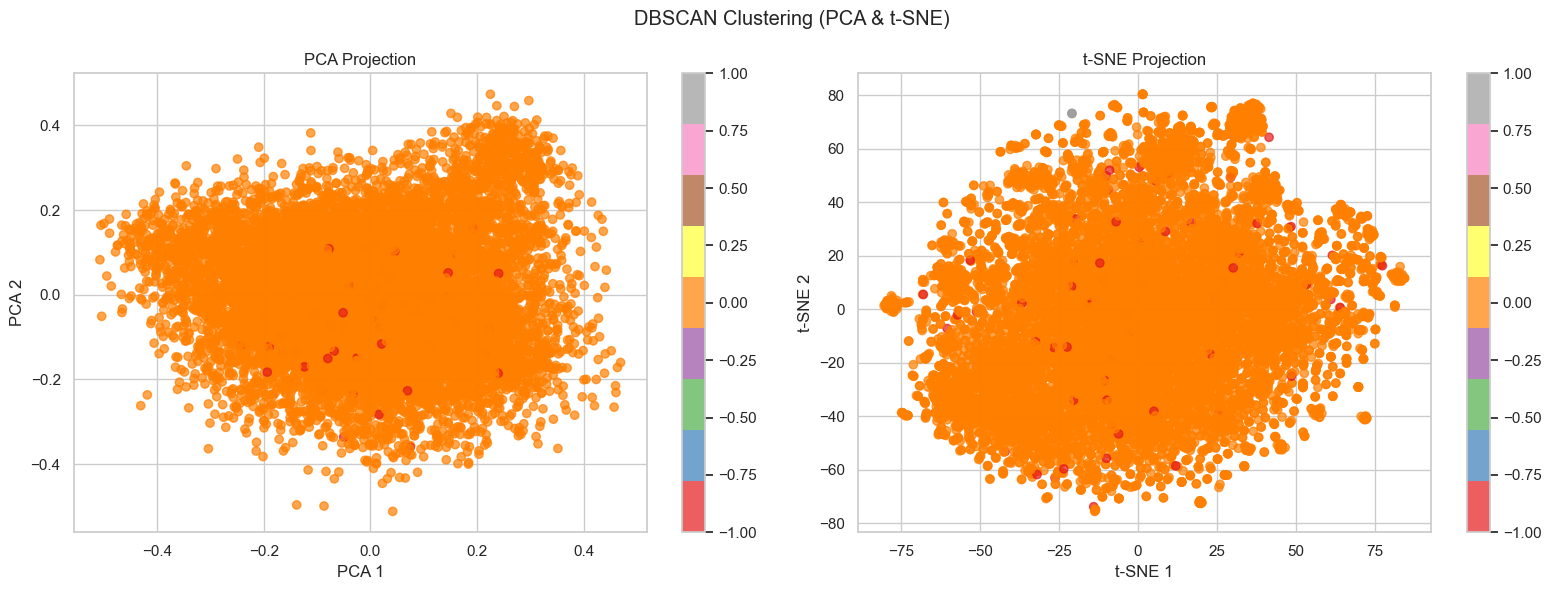

In [93]:
plot_clusters(emb_norm, df["cluster_dbscan"], title="DBSCAN Clustering (PCA & t-SNE)")

### Save DataFrame with DBSCAN Clusters

We now save the DataFrame that includes the original metadata and the DBSCAN cluster assignments.

In [94]:
output_path = "../data/dbscan_results.pkl"
df.to_pickle(output_path)
print(f"DataFrame saved to: {output_path}")

DataFrame saved to: ../data/dbscan_results.pkl
